In [3]:
import numpy as np
import tensorflow as tf
device_name = tf.test.gpu_device_name() 
if device_name != '/device:GPU:0':  
    raise SystemError('GPU device not found') 
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [247]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Flatten, Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from PIL import Image
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import random
import os
import tarfile
import shutil
from PIL import *


In [136]:
DIR= r'C:\Users\nasim\Documents\Morad\data\Money data'

SRC = DIR + '\validation'
DST = DIR + '\\testing'

In [74]:

for folder, subfolders, filenames in os.walk(SRC):
  if folder != SRC:
    name = folder.split('/')[-1]
    src_path = os.path.join(SRC, name)
    dst_path = os.path.join(DST, name)
    print(f'Current folder :{folder}\n')
    if not os.path.exists(dst_path):
      os.makedirs(dst_path)
    for file_ in filenames[len(filenames) // 2 :]:
      shutil.move(os.path.join(src_path, file_), dst_path)

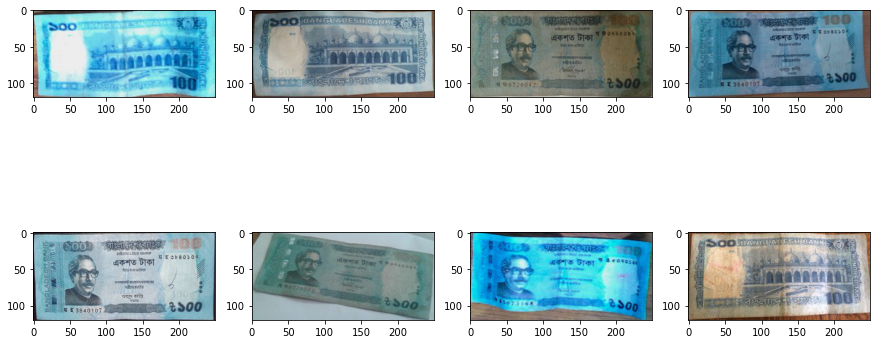

In [75]:
img_path_100 = DIR + '/training/100'
img_names = os.listdir(img_path_100)
fig, ax = plt.subplots(2, 4, figsize=(15, 7.5))
for i in range(2):
  for j in range(4):
    img_name = random.choice(img_names)
    img = plt.imread(img_path_100 + '/' + img_name)
    ax[i][j].imshow(img)

In [97]:
TRAINING_DATA_PATH = DIR + '\\training'
IMG_SIZE = (250, 500)
NUM_CLASSES = 9
VALID_DATA_DIR = DIR + '\\validation'
BATCH_SIZE = 6
NUM_EPOCH = 12
FREEZE_LAYERS = 16 
LEARNING_RATE = 0.0002
DROP_OUT = .2

In [98]:
VALID_DATA_DIR

'C:\\Users\\nasim\\Documents\\Morad\\data\\Money data\\validation'

In [99]:
model = Xception(include_top = False,
              weights = 'imagenet',
              input_tensor = None,
              input_shape = (250, 500, 3))

In [100]:
top_layer = model.output
x = GlobalAveragePooling2D()(top_layer)
op = Dense(NUM_CLASSES, activation = 'softmax', name = 'softmax')(x)
model_final = Model(inputs = model.input, outputs = op)

In [101]:
for layer in model_final.layers[:FREEZE_LAYERS]:
  layer.trainable = False

for layer in model_final.layers[FREEZE_LAYERS:]:
  layer.trainable = True

In [102]:
model_final.compile(optimizer = Adam(lr = LEARNING_RATE),
                    loss = 'categorical_crossentropy',
                    metrics = ['accuracy'])

In [103]:
print(model_final.summary())

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 250, 500, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 124, 249, 32) 864         input_6[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 124, 249, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 124, 249, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [142]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest',
                                   zoom_range = 0.3,
                                   width_shift_range = 0.3,
                                   height_shift_range = 0.3,
                                   rotation_range = 30)

In [143]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest',
                                   zoom_range = 0.3,
                                   width_shift_range = 0.3,
                                   height_shift_range = 0.3,
                                   rotation_range = 30)

In [144]:
train_batches = train_datagen.flow_from_directory(TRAINING_DATA_PATH,
                                                  target_size=IMG_SIZE,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  class_mode = 'categorical'
                                                  )

Found 1637 images belonging to 9 classes.


In [145]:

valid_batches = train_datagen.flow_from_directory(VALID_DATA_DIR,
                                                  target_size=IMG_SIZE,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  class_mode = 'categorical'
                                                  )

Found 456 images belonging to 9 classes.


In [108]:

class_dictionary = train_batches.class_indices
class_dictionary

{'1': 0,
 '10': 1,
 '100': 2,
 '1000': 3,
 '2': 4,
 '20': 5,
 '5': 6,
 '50': 7,
 '500': 8}

In [109]:
checkpoint = ModelCheckpoint('Xception_model.h5', monitor = 'val_accuracy', verbose = 1,
                             save_best_only = True, save_weights_only = False,
                             mode = 'auto')
early = EarlyStopping(monitor = 'val_accuracy', min_delta = 0, patience = 10,
                      verbose = 1, mode = 'auto')

In [110]:
history=model_final.fit_generator(train_batches,
                          steps_per_epoch = np.ceil(len(train_batches) / BATCH_SIZE),
                          validation_data = valid_batches,
                          validation_steps = np.ceil(len(valid_batches) / BATCH_SIZE),
                          epochs = NUM_EPOCH,
                          callbacks = [checkpoint, early])

Epoch 1/12
46/46 [==============================] - 28s 539ms/step - loss: 2.0345 - accuracy: 0.2525 - val_loss: 1.4831 - val_accuracy: 0.4872

Epoch 00001: val_accuracy improved from -inf to 0.48718, saving model to Xception_model.h5
Epoch 2/12
46/46 [==============================] - 24s 528ms/step - loss: 1.0032 - accuracy: 0.7351 - val_loss: 0.4775 - val_accuracy: 0.8462

Epoch 00002: val_accuracy improved from 0.48718 to 0.84615, saving model to Xception_model.h5
Epoch 3/12
46/46 [==============================] - 24s 528ms/step - loss: 0.5194 - accuracy: 0.8573 - val_loss: 0.3318 - val_accuracy: 0.9231

Epoch 00003: val_accuracy improved from 0.84615 to 0.92308, saving model to Xception_model.h5
Epoch 4/12
46/46 [==============================] - 24s 526ms/step - loss: 0.3926 - accuracy: 0.8566 - val_loss: 0.1427 - val_accuracy: 0.9744

Epoch 00004: val_accuracy improved from 0.92308 to 0.97436, saving model to Xception_model.h5
Epoch 5/12
46/46 [==============================] -

In [112]:
test_categories = os.listdir(DIR + '/testing')

In [113]:
class_dictionary

{'1': 0,
 '10': 1,
 '100': 2,
 '1000': 3,
 '2': 4,
 '20': 5,
 '5': 6,
 '50': 7,
 '500': 8}

In [114]:
vals = list(class_dictionary.values())
keys = list(class_dictionary.keys())

In [115]:
vals

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [116]:
keys

['1', '10', '100', '1000', '2', '20', '5', '50', '500']

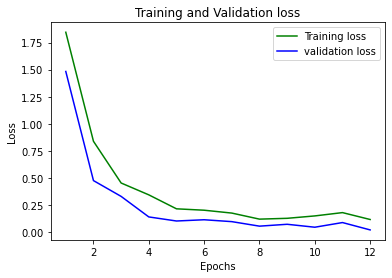

In [125]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,13)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

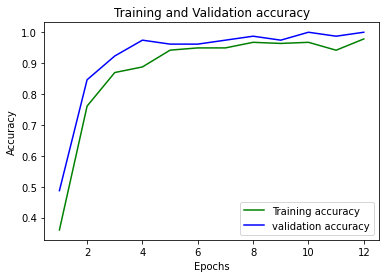

In [129]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,13)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Predicting on Test dataset

save the model

In [140]:
from tensorflow.keras.models import load_model

model_final.save('bd_money_Classifier.h5')

In [146]:
y_pred = model_final.predict(valid_batches) 

Load the model

In [147]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [205]:
model=load_model('bd_money_Classifier.h5')

Test the single image

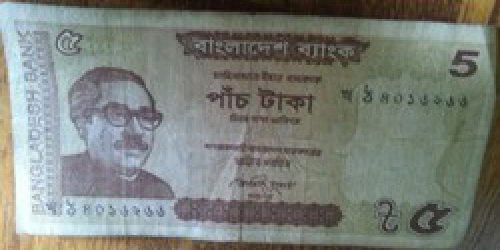

In [259]:
img=image.load_img(r'C:\Users\nasim\Documents\Morad\data\Money data\testing\5\5_27.jpg',target_size=(250, 500))
img

In [260]:
test_image=image.img_to_array(img)
test_image=np.expand_dims(test_image, axis = 0)

In [261]:
result = model_final.predict(test_image)
result

array([[9.358139e-18, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        1.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00]], dtype=float32)

In [262]:
a=np.argmax(model.predict(test_image), axis=1)

In [263]:
a

array([4], dtype=int64)

In [264]:
classes

array([[4.9729844e-13, 0.0000000e+00, 0.0000000e+00, 8.2975412e-30,
        1.0000000e+00, 0.0000000e+00, 7.9238458e-32, 0.0000000e+00,
        0.0000000e+00]], dtype=float32)